## Tiger Census
* https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
* S1200 - secondary road
* S1100 - primary road
* S1400 - local roads


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg

import geopandas as gpd
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
import datetime


from segment_speed_utils.project_vars import analysis_date
from segment_speed_utils import helpers
from shared_utils import  dask_utils, geography_utils, utils

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/"
SHARED_GCS = f"{GCS_FILE_PATH}shared_data/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/dask_geopandas/backends.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/l

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### Tiger - Load Roads

In [3]:
def load_roads(road_type_wanted:list, buffer_or_not: bool = False):
    """
    Load some or all of the roads based on what you filter.
    Can also buffer the roads or not. 
    
    Args:
        road_type_wanted (list): the type of roads you want.
        https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
        
        buffer_or_not (bool): add a buffer of 200 or not
    
    Returns: 
        GeoDataFrame
    """
    df = gpd.read_parquet(
         f"{SHARED_GCS}all_roads_2020_state06.parquet", 
         filters =[('MTFCC', 'in', road_type_wanted)],
         columns = ["LINEARID","geometry", "FULLNAME"]
    ).to_crs(geography_utils.CA_NAD83Albers)
    
        
    if buffer_or_not:
        df = df.assign(
            geometry = df.geometry.buffer(200)
        )
    else:
        df
        
    df = to_snakecase(df)
    
    return df

In [5]:
local_primary_seconary_og_rds = load_roads(['S1400', 'S1100','S1200'])

In [7]:
local_primary_seconary_og_rds.linearid.nunique()

953914

In [12]:
# Local roads that are sjoined to bus routes, not segmented
local_roads = gpd.read_parquet(f'{SHARED_GCS}local_roads_gtfs_shapes_sjoin.parquet')

In [13]:
local_roads.linearid.nunique()

310430

In [14]:
# All primary/secondary roads regardless of instersection w bus routes
# Segmented
primary_secondary = gpd.read_parquet(f'{SHARED_GCS}segmented_primary_secondary_roads.parquet')

In [15]:
primary_secondary.linearid.nunique()

7363

In [16]:
local_primary_seconary_og_rds.linearid.nunique() - (primary_secondary.linearid.nunique() + local_roads.linearid.nunique())

636121

<AxesSubplot:>

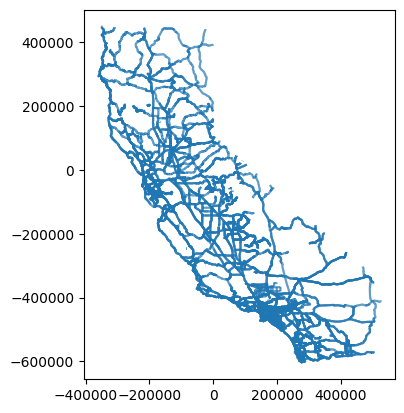

In [19]:
primary_secondary.plot()

<AxesSubplot:>

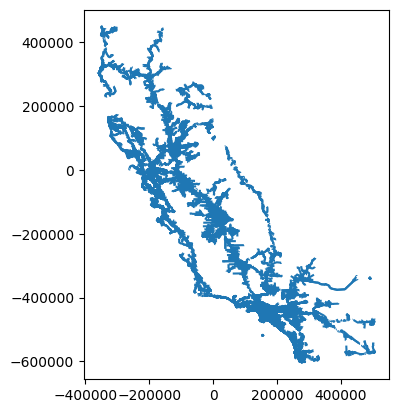

In [20]:
local_roads.plot()

<AxesSubplot:>

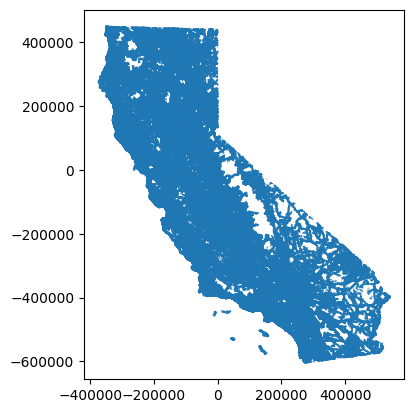

In [17]:
local_primary_seconary_og_rds.plot()

### GTFS Shapes

In [ ]:
def gtfs_shapes_operators_dask(date):
    """
    Load and merge gtfs_shapes 
    with trips to get operator and 
    feed key information.
    
    Args:
        date: date wanted for the datasets to be drawn from
        
    Returns:
        GeoDataFrame
    """
    gtfs_shapes = helpers.import_scheduled_shapes(date)
    
    trips = helpers.import_scheduled_trips(date,(),['name','shape_array_key']).drop_duplicates()
    
    m1 = dd.merge(gtfs_shapes, trips, how="outer", on="shape_array_key")
    
    return m1

In [ ]:
def gtfs_shapes_operators(date):
    """
    Load and merge gtfs_shapes 
    with trips to get operator and 
    feed key information.
    
    Args:
        date: date wanted for the datasets to be drawn from
        
    Returns:
        GeoDataFrame
    """
    gtfs_shapes = helpers.import_scheduled_shapes(date).compute()
    
    trips = helpers.import_scheduled_trips(date,(),['name','shape_array_key']).compute().drop_duplicates()
    
    m1 = pd.merge(gtfs_shapes, trips, how="outer", on="shape_array_key")
    
    return m1

In [ ]:
def order_operators(date) -> list:
    """
    Re order a list of operators so some of the largest
    ones will be at the top of the list.
     
    Args:
        date: date wanted for the datasets to be drawn from   
    """
    operator_list = helpers.import_scheduled_trips(analysis_date,(),['name']).compute().sort_values('name')
    operator_list = operator_list.name.unique().tolist()
    
    # Reorder list so the biggest operators are at the beginning
    # based on NTD services data 
    big_operators = ['LA DOT Schedule',
     'LA Metro Bus Schedule',
     'LA Metro Rail Schedule',
     'Bay Area 511 Muni Schedule',
     'Bay Area 511 AC Transit Schedule',
     'Bay Area 511 Santa Clara Transit Schedule',
     'Bay Area 511 BART Schedule',
     'San Diego Schedule','OCTA Schedule','Sacramento Schedule',
    ]
    i = 0
    for operator in big_operators:
        operator_list.remove(operator)
        operator_list.insert(i, operator)
        ++i
    return operator_list

### Tiger Local Roads
#### Test w/ LA Metro first - 25 minutes long

In [ ]:
#one_op = 'Bear Schedule'

In [ ]:
#shapes_filtered = shapes.loc[shapes.name == one_op].reset_index(drop = True)

In [ ]:
#sjoin1 = gpd.sjoin(
#        local_roads,
#       shapes_filtered,
 #       how = "inner",
 #     predicate = "intersects").drop_duplicates().reset_index(drop=True)

In [ ]:
#sjoin1.shape

In [ ]:
#sjoin1.linearid.nunique()

In [ ]:
#sjoin1.columns

In [ ]:
#linearid_del = sjoin1.linearid.unique().tolist()

In [ ]:
#localroads_filtered = local_roads[~local_roads.linearid.isin(linearid_del)].reset_index(drop = True)

In [ ]:
#local_roads.linearid.nunique() - localroads_filtered.linearid.nunique()

In [ ]:
# shapes = gtfs_shapes_operators(analysis_date)

In [ ]:
# local_roads.linearid.nunique(), local_roads.linearid.count()

In [ ]:
# local_roads.linearid.count()-local_roads.linearid.nunique()

In [ ]:
# shapes_filtered.name.unique()

In [ ]:
# sjoin_full_results = pd.DataFrame()

In [ ]:
"""
for operator in test_operators:
        try:
            linearid_to_delete = sjoin_full_results.linearid.unique().tolist()
            local_roads = local_roads[~local_roads.linearid.isin(linearid_to_delete)].reset_index(drop = True)
        except:
            pass
        
        shapes_filtered = shapes.loc[shapes.name == operator].reset_index(drop = True)
    
        sjoin1 = gpd.sjoin(
        local_roads,
        shapes_filtered,
        how = "inner",
        predicate = "intersects").drop_duplicates().reset_index(drop=True)
        
        sjoin_full_results = pd.concat([sjoin_full_results, sjoin1], axis=0)"""

In [ ]:
#sjoin_full_results.shape

In [ ]:
#sjoin_full_results.linearid.nunique()

In [ ]:
#sjoin_full_results.linearid.count()

In [ ]:
#sjoin_full_results.drop(columns = ['geometry']).sample(5)

In [ ]:
# test_operators = ['LA DOT Schedule','Bell Gardens Schedule','Nevada County Schedule','San Diego Schedule','OCTA Schedule','Sacramento Schedule']

In [ ]:
# test_localroads = join_local_roads(analysis_date)

In [ ]:
# test_localroads.shape

In [ ]:
# f"{GCS_FILE_PATH}shared_data/"

In [ ]:
# f'{SHARED_GCS}local_roads_gtfs_shapes.parquet'

In [ ]:
# test_localroads.linearid.nunique()

In [ ]:
# local_roads = load_roads(['S1400'])

In [ ]:
# local_roads.linearid.nunique()

In [ ]:
# test_localroads.linearid.nunique()

In [ ]:
def la_metro(date):
    
    # Load Shapes
    gtfs_shape_gdf = gtfs_shapes_operators(date)
    
    # Load local roads - buffered
    local_roads_buffered = load_roads(['S1400'], True)

    # Load local roads - not buffered
    local_roads_og = load_roads(['S1400'], False)
    
    # Empty dataframe
    sjoin_full_results = pd.DataFrame()
    
    # Loop through and join by operator
    for operator in ['LA Metro Bus Schedule',
     'LA Metro Rail Schedule',]:
        
        shapes_filtered = gtfs_shape_gdf.loc[gtfs_shape_gdf.name == operator].reset_index(drop = True)
        
        # Delete any local road linearids that have already been found by an operator
        try:
            linearid_to_delete = sjoin_full_results.linearid.unique().tolist()
            local_roads_buffered = local_roads_buffered[~local_roads_buffered.linearid.isin(linearid_to_delete)].reset_index(drop = True)
        except:
            pass
        
        sjoin1 = (gpd.sjoin(
        local_roads_buffered,
        shapes_filtered,
        how = "inner",
        predicate = "intersects")
                  [['linearid']]
                  .drop_duplicates()
                  .reset_index(drop=True)
                 )
        
        sjoin_full_results = pd.concat([sjoin_full_results, sjoin1], axis=0)
    
    sjoin_full_results = sjoin_full_results.drop_duplicates()
    
    # Merge back to original local roads -> a GDF
    merge1 = pd.merge(
        local_roads_og,
        sjoin_full_results,
        on = "linearid",
        how = "inner")
    
    # Fill in null values for fullname
    merge1.fullname = merge1.fullname.fillna('None') 
    
    # Save
    print('Done with LA Metro')
    
    return merge1

In [ ]:
# 2023-04-10 11:20:11.194365
# Done with LA Metro
# time lapsed: 0:25:57.435602
def cut_metro(date):
    start = datetime.datetime.now()
    print(start)
    
    # Find local roads that intersect  with LA Metro
    local_roads = la_metro(date)
    
    segments = geography_utils.cut_segments(
        local_roads,
        ["linearid", "fullname"],
        1_000 # 1 km segments
    )
    
    end = datetime.datetime.now()
    print(f"time lapsed: {end-start}")
    
    return segments
    

#### Cut all roads

In [ ]:
def cut_local_roads(date):
    start = datetime.datetime.now()
    # Load Shapes
    gtfs_shape_gdf = gtfs_shapes_operators(date)
    
    # Load local roads - buffered
    local_roads_buffered = load_roads(['S1400'], True)

    # Load local roads - not buffered
    local_roads_og = load_roads(['S1400'], False)
    
    # Find all unique operators, ordered by
    # largest operators first
    operators_list = order_operators(date)
    
    # Empty dataframe
    sjoin_full_results = pd.DataFrame()
    
    # Loop through and join by operator
    for operator in operators_list:
        
        shapes_filtered = gtfs_shape_gdf.loc[gtfs_shape_gdf.name == operator].reset_index(drop = True)
        
        # Delete any local road linearids that have already been found by an operator
        try:
            linearid_to_delete = sjoin_full_results.linearid.unique().tolist()
            local_roads_buffered = local_roads_buffered[~local_roads_buffered.linearid.isin(linearid_to_delete)].reset_index(drop = True)
        except:
            pass
        
        sjoin1 = (gpd.sjoin(
        local_roads_buffered,
        shapes_filtered,
        how = "inner",
        predicate = "intersects")
                  [['linearid']]
                  .drop_duplicates()
                  .reset_index(drop=True)
                 )
        
        sjoin_full_results = pd.concat([sjoin_full_results, sjoin1], axis=0)
    
    sjoin_full_results = sjoin_full_results.drop_duplicates()
    sjoin_full_results.to_parquet(f'{SHARED_GCS}local_roads_gtfs_shapes.parquet')
    
    # Merge back to original local roads -> a GDF
    merge1 = pd.merge(
        local_roads_og,
        sjoin_full_results,
        on = "linearid",
        how = "inner")
    
    
    # Fill in null values for fullname
    merge1.fullname = merge1.fullname.fillna('None') 
    
    # Save
    merge1.to_parquet(f'{SHARED_GCS}local_roads_gtfs_shapes_sjoin.parquet')
    print('Done with sjoin local roads')

    segments = geography_utils.cut_segments(
        merge1,
        ["linearid", "fullname"],
        1_000 # 1 km segments
    )
    
    segments.to_parquet(f'{SHARED_GCS}segmented_local_roads_gtfs_shapes.parquet')
    end = datetime.datetime.now()
    print(f"time lapsed for cutting local roads: {end-start}")
    return segments

### Concat local roads and primary/secondary ones

In [10]:
def cut_primary_secondary_roads():
    start = datetime.datetime.now()
    print(start)
    
    # Find all primary and secondary roads
    # regardless of intersection w/ GTFS shapes
    primary_secondary_mtfcc = ['S1100','S1200']
    primary_secondary_roads = load_roads(primary_secondary_mtfcc)
    
    segments = geography_utils.cut_segments(
        primary_secondary_roads,
        ["linearid", "fullname"],
        1_000 # 1 km segments
    )
    
    segments.to_parquet(f"{SHARED_GCS}segmented_primary_secondary_roads.parquet")
    
    end = datetime.datetime.now()
    print(f"time lapsed for cutting primary & secondary roads: {end-start}")
    return segments
    

In [11]:
primary_secondary = cut_primary_secondary_roads()

2023-04-11 14:50:11.222530
time lapsed for cutting primary & secondary roads: 0:03:14.569147


In [ ]:
def cut_all_roads(date):
    start = datetime.datetime.now()
    
    # Segment primary and secondary roads
    segmented_primary_secondary_rds = cut_primary_secondary_roads()
    
    # Find local roads that intersect  with GTFS shapes, then
    # segment them
    local_roads_gdf = cut_local_roads(date)
    
    # Concat 
    all_roads = pd.concat([segmented_primary_secondary_rds, segmented_local_rds], axis=0)
    all_roads.to_parquet(f"{SHARED_GCS}segmented_all_roads.parquet")
    
    end = datetime.datetime.now()
    print(f"time lapsed: {end-start}")

In [ ]:
test_all_roads = cut_all_roads(analysis_date)

### Draft

In [ ]:
"""
def join_primary_secondary(gtfs_shape_gdf):
    
    # Load secondary-primary roads
    primary_secondary_mtfcc = ['S1100','S1200']
    primary_secondary_roads = load_roads(primary_secondary_mtfcc)
    
    sjoin1 = gpd.sjoin(
        primary_secondary_roads,
        gtfs_shape_gdf,
        how = "inner",
        predicate = "intersects"
    ).drop_duplicates().reset_index(drop=True)
    
    # Save to GCS
    sjoin1.to_parquet(f'{SHARED_GCS}primary_secondary_roads_gtfs_shapes.parquet')
    print('Done with primary and secondary roads')
    return sjoin1
    """

In [ ]:
def gtfs_shapes_all_roads(date):
    
    start = datetime.datetime.now()
    print(start)
    
    # Find all primary and secondary roads
    # regardless of intersection
    primary_secondary_mtfcc = ['S1100','S1200']
    primary_secondary_roads = load_roads(primary_secondary_mtfcc)
    
    # Find local roads that intersect  with GTFS shapes
    local_roads_gdf = join_local_roads(date)
    
    # Concat 
    all_roads = pd.concat([primary_secondary_roads, local_roads_gdf], axis=0)
    
    # Save
    all_roads.to_parquet(f'{SHARED_GCS}intersected_local_all_primary_sec_roads.parquet')
    
    """
    # Find segments
    segments = geography_utils.cut_segments(
        all_roads,
        ["linearid", "fullname"],
        1_000 # 1 km segments
    )
    
    segments.to_parquet(f"{SHARED_GCS}census_road_segments.parquet")
    """
    end = datetime.datetime.now()
    print(f"time lapsed: {end-start}")
    return all_roads